In [1]:
# import modules
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, SeparableConv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

In [2]:
tf

<module 'tensorflow' from '/opt/conda/lib/python3.6/site-packages/tensorflow/__init__.py'>

In [3]:
#Pre-process images
import os
import cv2
import matplotlib.pyplot as plt

train_path = '../input/wnet-data-large/data_large/Data_Large/train/'
val_path = '../input/wnet-data-large/data_large/Data_Large/val/'

train_images = os.listdir(train_path)
val_images = os.listdir(val_path)

X_train = []
X_val = []

# Prepare X_train

for i in range(len(train_images)):
    img = cv2.imread(train_path+train_images[i]) #read all images
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # Convert images to Grayscale
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) #Resize image to (224, 224)
    X_train.append(resized) # append to list
    
X_train = np.asarray(X_train) #convert to numpy array
X_train = X_train/255 # Standardizing the data
X_train = np.reshape(X_train, (len(X_train), 224, 224, 1)) #reshape it to (1140, 224, 224, 1) for feeding to model

#Prepare X_val

for i in range(len(val_images)):
    img = cv2.imread(val_path+val_images[i]) #read all images
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)  # Convert images to Grayscale
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA) #Resize image to (224, 224)
    X_val.append(resized) # append to list
    
X_val = np.asarray(X_val) #convert to numpy array
X_val = X_val/255 # Standardizing the data
X_val = np.reshape(X_val, (len(X_val), 224, 224, 1)) #reshape it to (100, 224, 224, 1) fro feeding to model

print("Number of train images:",len(X_train), "Shape of X_train:", X_train.shape)
print("Number of val images:",len(X_val), "Shape of X_val:", X_val.shape)

Number of train images: 1140 Shape of X_train: (1140, 224, 224, 1)
Number of val images: 100 Shape of X_val: (100, 224, 224, 1)


In [4]:
# from keras.datasets import mnist
# import numpy as np
# (X_train, _), (X_val, _) = mnist.load_data()

# X_train = X_train.astype('float32') / 255.
# X_val = X_val.astype('float32') / 255.
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_val = X_val.reshape((len(X_val), np.prod(X_val.shape[1:])))
# print (X_train.shape)
# print (X_val.shape)

In [5]:
# Shuffle X_train and X_val
np.random.shuffle(X_train)
np.random.shuffle(X_val)

In [6]:
#Parameters
input_img = Input(shape=(224, 224, 1)) #input image shape
droprate=0.0 #rate for dropout layers
droprate_input = 0.8 #rate for input layers (not used)
num_classes = 2 #background, cell
num_epochs = 10 
ae_lr = 0.001 #learning rate for auto_encoder which outputs the reconstruction of the original image.
enc_lr = 0.00001 #learning rate for encoder from which outputs the segmentation of the original image.
num_batches = 76
batch_size = len(X_train)//num_batches
batch_size


15

In [7]:
#Concatination layer for skip connections in the network
def upconv_concat(bottom_a, bottom_b, n_filter, pool_size, stride, padding='VALID'):
    up_conv = Conv2DTranspose(filters=n_filter, kernel_size=[pool_size, pool_size],
                                         strides=stride, padding=padding)(bottom_a)
    return Concatenate(axis=-1)([up_conv, bottom_b])


In [12]:
#Encoder

# To view the model architecture, view the paper: https://arxiv.org/pdf/1711.08506.pdf
#Module 1
conv_1_1 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(input_img)
conv_1_1_bn = BatchNormalization()(conv_1_1)
conv_1_1_do = Dropout(droprate)(conv_1_1_bn)

conv_1_2 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_1_1_do)
conv_1_2_bn = BatchNormalization()(conv_1_2)
conv_1_2_do = Dropout(droprate)(conv_1_2_bn)

pool_1 = MaxPooling2D(pool_size= 2, strides = 2)(conv_1_2_do) #Module 1 to Module 2

#Module 2

conv_2_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(pool_1)
conv_2_1_bn = BatchNormalization()(conv_2_1)
conv_2_1_do = Dropout(droprate)(conv_2_1_bn)

conv_2_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_2_1_do)
conv_2_2_bn = BatchNormalization()(conv_2_2)
conv_2_2_do = Dropout(droprate)(conv_2_2_bn)

pool_2 = MaxPooling2D(pool_size= 2, strides = 2)(conv_2_2_do) #Module 2 to Module 3

#Module 3

conv_3_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(pool_2)
conv_3_1_bn = BatchNormalization()(conv_3_1)
conv_3_1_do = Dropout(droprate)(conv_3_1_bn)

conv_3_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_3_1_do)
conv_3_2_bn = BatchNormalization()(conv_3_2)
conv_3_2_do = Dropout(droprate)(conv_3_2_bn)

pool_3 = MaxPooling2D(pool_size= 2, strides = 2)(conv_3_2_do) #Module 3 to Module 4

#Module 4

conv_4_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(pool_3)
conv_4_1_bn = BatchNormalization()(conv_4_1)
conv_4_1_do = Dropout(droprate)(conv_4_1_bn)

conv_4_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_4_1_do)
conv_4_2_bn = BatchNormalization()(conv_4_2)
conv_4_2_do = Dropout(droprate)(conv_4_2_bn)

pool_4 = MaxPooling2D(pool_size= 2, strides = 2)(conv_4_2_do) #Module 4 to Module 5

#Module 5

conv_5_1 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(pool_4)
conv_5_1_bn = BatchNormalization()(conv_5_1)
conv_5_1_do = Dropout(droprate)(conv_5_1_bn)

conv_5_2 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(conv_5_1_do)
conv_5_2_bn = BatchNormalization()(conv_5_2)
conv_5_2_do = Dropout(droprate)(conv_5_2_bn)

upconv_1 = upconv_concat(conv_5_2_do, conv_4_2_do, n_filter=512, pool_size=2, stride=2) #Module 5 to 6

#Module 6

conv_6_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(upconv_1)
conv_6_1_bn = BatchNormalization()(conv_6_1)
conv_6_1_do = Dropout(droprate)(conv_6_1_bn)

conv_6_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_6_1_do)
conv_6_2_bn = BatchNormalization()(conv_6_2)
conv_6_2_do = Dropout(droprate)(conv_6_2_bn)

upconv_2 = upconv_concat(conv_6_2_do, conv_3_2_do, n_filter=256, pool_size=2, stride=2) #Module 6 to 7

#Module 7

conv_7_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(upconv_2)
conv_7_1_bn = BatchNormalization()(conv_7_1)
conv_7_1_do = Dropout(droprate)(conv_7_1_bn)

conv_7_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_7_1_do)
conv_7_2_bn = BatchNormalization()(conv_7_2)
conv_7_2_do = Dropout(droprate)(conv_7_2_bn)

upconv_3 = upconv_concat(conv_7_2_do, conv_2_2_do, n_filter=128, pool_size=2, stride=2) #Module 7 to 8

#Module 8

conv_8_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(upconv_3)
conv_8_1_bn = BatchNormalization()(conv_8_1)
conv_8_1_do = Dropout(droprate)(conv_8_1_bn)

conv_8_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_8_1_do)
conv_8_2_bn = BatchNormalization()(conv_8_2)
conv_8_2_do = Dropout(droprate)(conv_8_2_bn)

upconv_4 = upconv_concat(conv_8_2_do, conv_1_2_do, n_filter=64, pool_size=2, stride=2) #Module 8 to 9

#Module 9

conv_9_1 = SeparableConv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(upconv_4)
conv_9_1_bn = BatchNormalization()(conv_9_1)
conv_9_1_do = Dropout(droprate)(conv_9_1_bn)

conv_9_2 = SeparableConv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_9_1_do)
conv_9_2_bn = BatchNormalization()(conv_9_2)
conv_9_2_do = Dropout(droprate)(conv_9_2_bn)

# encoder_output = Custom_Conv()(conv_9_2_do, k_size=1, num_outputs=3, stride=1) 

final_conv = Conv2D(num_classes, 1, 1)(conv_9_2_do)

# we have to apply softmax on all pixels.

x = Reshape((224*224, num_classes,))(final_conv) 
# x = Permute((2,1))(x)
x = Activation("softmax")(x)

# Reshape it agian to feed it to the decoder
encoder_output = Reshape((224, 224, num_classes))(x) #Module 9 to 10

In [13]:
#Decoder

#Module 10

conv_10_1 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(encoder_output)
conv_10_1_bn = BatchNormalization()(conv_10_1)
conv_10_1_do = Dropout(droprate)(conv_10_1_bn)

conv_10_2 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_10_1_do)
conv_10_2_bn = BatchNormalization()(conv_10_2)
conv_10_2_do = Dropout(droprate)(conv_10_2_bn)

pool_5 = MaxPooling2D(pool_size= 2, strides = 2)(conv_10_2_do) #Module 10 to 11

#Module 11

conv_11_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(pool_5)
conv_11_1_bn = BatchNormalization()(conv_11_1)
conv_11_1_do = Dropout(droprate)(conv_11_1_bn)

conv_11_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_11_1_do)
conv_11_2_bn = BatchNormalization()(conv_11_2)
conv_11_2_do = Dropout(droprate)(conv_11_2_bn)

pool_6 = MaxPooling2D(pool_size= 2, strides = 2)(conv_11_2_do) #Module 11 to 12

#Module 12

conv_12_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(pool_6)
conv_12_1_bn = BatchNormalization()(conv_12_1)
conv_12_1_do = Dropout(droprate)(conv_12_1_bn)

conv_12_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_12_1_do)
conv_12_2_bn = BatchNormalization()(conv_12_2)
conv_12_2_do = Dropout(droprate)(conv_12_2_bn)

pool_7 = MaxPooling2D(pool_size= 2, strides = 2)(conv_12_2_do) #Module 12 to 13

#Module 13

conv_13_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(pool_7)
conv_13_1_bn = BatchNormalization()(conv_13_1)
conv_13_1_do = Dropout(droprate)(conv_13_1_bn)

conv_13_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_13_1_do)
conv_13_2_bn = BatchNormalization()(conv_13_2)
conv_13_2_do = Dropout(droprate)(conv_13_2_bn)

pool_8 = MaxPooling2D(pool_size= 2, strides = 2)(conv_13_2_do) #Module 13 to 14

#Module 14

conv_14_1 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(pool_8)
conv_14_1_bn = BatchNormalization()(conv_14_1)
conv_14_1_do = Dropout(droprate)(conv_14_1_bn)

conv_14_2 = SeparableConv2D(filters = 1024, kernel_size = 3, activation='relu', padding='same')(conv_14_1_do)
conv_14_2_bn = BatchNormalization()(conv_14_2)
conv_14_2_do = Dropout(droprate)(conv_14_2_bn)

upconv_5 = upconv_concat(conv_14_2_do, conv_13_2_do, n_filter=512, pool_size=2, stride=2)  #Module 14 to 15

#Module 15

conv_15_1 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(upconv_5)
conv_15_1_bn = BatchNormalization()(conv_15_1)
conv_15_1_do = Dropout(droprate)(conv_15_1_bn)

conv_15_2 = SeparableConv2D(filters = 512, kernel_size = 3, activation='relu', padding='same')(conv_15_1_do)
conv_15_2_bn = BatchNormalization()(conv_15_2)
conv_15_2_do = Dropout(droprate)(conv_15_2_bn)

upconv_6 = upconv_concat(conv_15_2_do, conv_12_2_do, n_filter=256, pool_size=2, stride=2)  #Module 15 to 16

#Module 16

conv_16_1 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(upconv_6)
conv_16_1_bn = BatchNormalization()(conv_16_1)
conv_16_1_do = Dropout(droprate)(conv_16_1_bn)

conv_16_2 = SeparableConv2D(filters = 256, kernel_size = 3, activation='relu', padding='same')(conv_16_1_do)
conv_16_2_bn = BatchNormalization()(conv_16_2)
conv_16_2_do = Dropout(droprate)(conv_16_2_bn)

upconv_7 = upconv_concat(conv_16_2_do, conv_11_2_do, n_filter=128, pool_size=2, stride=2)  #Module 16 to 17

#Module 17

conv_17_1 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(upconv_7)
conv_17_1_bn = BatchNormalization()(conv_17_1)
conv_17_1_do = Dropout(droprate)(conv_17_1_bn)

conv_17_2 = SeparableConv2D(filters = 128, kernel_size = 3, activation='relu', padding='same')(conv_17_1_do)
conv_17_2_bn = BatchNormalization()(conv_17_2)
conv_17_2_do = Dropout(droprate)(conv_17_2_bn)

upconv_8 = upconv_concat(conv_17_2_do, conv_10_2_do, n_filter=64, pool_size=2, stride=2)  #Module 17 to 18

#Module 18

conv_18_1 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(upconv_8)
conv_18_1_bn = BatchNormalization()(conv_18_1)
conv_18_1_do = Dropout(droprate)(conv_18_1_bn)

conv_18_2 = Conv2D(filters = 64, kernel_size = 3, activation='relu', padding='same')(conv_18_1_do)
conv_18_2_bn = BatchNormalization()(conv_18_2)
conv_18_2_do = Dropout(droprate)(conv_18_2_bn)

decoder_output =  Conv2D(filters = 1, kernel_size = 1, activation='relu', padding='same')(conv_18_2_do)

## Encoder Model

In [14]:
encoder_model = Model(input_img, encoder_output)

In [15]:
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 224, 224, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_36 (Batc (None, 224, 224, 64) 256         conv2d_8[0][0]                   
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 224, 224, 64) 0           batch_normalization_v1_36[0][0]  
__________________________________________________________________________________________________
conv2d_9 (

## Calculate Soft Normalization Cut

In [16]:
from scipy.stats import norm
import torch
import torch.nn.functional as F

In [17]:
radius = 4
sigma_std = 5.0
sigma_pixel = 1.0

In [18]:
def gaussian_kernel(radius, sigma):
    x_2 = np.linspace(-radius, radius, 2*radius+1) ** 2
    dist = np.sqrt(x_2.reshape(-1, 1) + x_2.reshape(1, -1)) / sigma
    kernel = norm.pdf(dist) / norm.pdf(0)
    kernel = tf.convert_to_tensor(kernel)
    kernel = tf.reshape(kernel, (kernel.shape[0], kernel.shape[1], 1, 1))
    return kernel
kernel = gaussian_kernel(radius=radius, sigma=sigma_std)
kernel = tf.cast(kernel, tf.float32)
kernel.shape

TensorShape([Dimension(9), Dimension(9), Dimension(1), Dimension(1)])

In [19]:
def soft_cut_norm_loss(y_true, y_pred):
    loss = 0
    for k in range(num_classes):
        
        class_probs = y_pred[:,:,:, k:k+1]

        class_mean = tf.reduce_mean(y_true * class_probs, axis = [1,2], keepdims=True) / \
        tf.add(tf.reduce_mean(class_probs, axis = [1,2], keepdims=True), 1e-5)

        diff = tf.reduce_sum(tf.pow((y_true - class_mean), 2), 0, keepdims=True)

        # Weight the loss by the difference from the class average.
        weights = tf.exp(tf.multiply(tf.pow(diff, 2) , -1/ sigma_pixel ** 2))

        # Compute N-cut loss, using the computed weights matrix, and a Gaussian spatial filter
        numerator = tf.reduce_sum(class_probs * tf.nn.conv2d(class_probs * weights, kernel, strides = [1, 1, 1, 1], padding='SAME'))
        denominator = tf.reduce_sum(class_probs * tf.nn.conv2d(weights, kernel, strides = [1, 1, 1, 1], padding="SAME"))
        loss += numerator / tf.add(denominator, 1e-6)

    return num_classes - loss

In [20]:
init1 = tf.global_variables_initializer()
init2 = tf.local_variables_initializer()

In [21]:
with tf.Session() as sess:
    sess.run(init1)
    opt = tf.keras.optimizers.Adam(lr = 0.00001, beta_1 = 0.9, beta_2 = 0.999)
    encoder_model.compile(optimizer=opt, loss=soft_cut_norm_loss)
    history = encoder_model.fit(X_train, X_train,
                    epochs=10,
                    batch_size=batch_size,
                    shuffle=True).history

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/10
1140/1140 [==============================] - 58s 51ms/sample - loss: 0.6136
Epoch 2/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.2752
Epoch 3/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.1456
Epoch 4/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.1072
Epoch 5/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.0901
Epoch 6/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.0805
Epoch 7/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.0745
Epoch 8/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.0700
Epoch 9/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.0667
Epoch 10/10
1140/1140 [==============================] - 49s 43ms/sample - loss: 0.0633


In [22]:
# # Train encoder model
# with tf.Session() as sess:
#     sess.run(init1)
#     sess.run(init2)
#     for epoch in range(num_epochs):
#         print("epoch:", epoch)
#         count = 0
#         batch_start_index = 0
#         while (count != num_batches):
#             X_train_batch = X_train[batch_start_index : batch_start_index+batch_size] #send a batch of input images of size (batchsize, 224, 224, 1)
#             _, train_loss = sess.run([norm_cut_opt,norm_cut_loss], feed_dict={original_image: X_train_batch})
#             batch_start_index+=batch_size
#             count+=1
#         print("Train loss after ", str(epoch), "is", str(train_loss))

In [ ]:
init1 = tf.global_variables_initializer()

In [ ]:
with tf.Session() as sess:
    sess.run(init1)
    encoder_model.save("encoder_model_100.h5")
    json_string = encoder_model.to_json()
    encoder_model.save_weights('encoder_model_100_weights.h5')

In [ ]:
!ls

In [ ]:
import pickle as serializer

with open('model_json.txt', 'w') as f:
    f.write(str(json_string))


## Full model

In [ ]:
# wnet_autoencoder = Model(input_img, decoder_output)

In [ ]:
# wnet_autoencoder.summary()

In [ ]:
# #place holders for wnet_autoencoder
# input_image = tf.placeholder(dtype=tf.float32, shape=[None, 224, 224, 1])

# # Reconstruction loss and loss for autoencoder model
# rec_loss = tf.reduce_mean(tf.squared_difference(wnet_autoencoder(input_image), input_image))
# rec_opt = tf.train.GradientDescentOptimizer(learning_rate=ae_lr).minimize(rec_loss)

# init1 = tf.global_variables_initializer()
# init2 = tf.local_variables_initializer()

In [ ]:
# #train autoencoder
# with tf.Session() as sess:
#     sess.run(init1)
#     sess.run(init2)
#     for epoch in range(num_epochs):
#         print("epoch:", epoch)
#         count = 0
#         batch_start_index = 0
#         while (count != num_batches):
#             X_train_batch = X_train[batch_start_index : batch_start_index+batch_size]
#             _, train_loss = sess.run([rec_opt,rec_loss], feed_dict={input_image: X_train_batch})
#             batch_start_index+=batch_size
#             count+=1
#         print("Train loss after ", str(epoch), "is", str(train_loss))
        

In [ ]:
# Train full Auto-Encoder with keras

# with tf.Session() as sess:
#     sess.run(init1)
#     sess.run(init2)
#     wnet_autoencoder.compile(optimizer='adagrad', loss='mean_squared_error')
#     history = wnet_autoencoder.fit(X_train, X_train,
#                     epochs=5,
#                     batch_size=8,
#                     shuffle=True,
#                     validation_data=(X_val, X_val)).history

In [ ]:
# Train Encoder with keras. 

# with tf.Session() as sess:
#     sess.run(init1)
#     sess.run(init2)
#     encoder_model.compile(optimizer='adagrad', loss='sparse_categorical_crossentropy')
#     history = encoder_model.fit(X_train, X_train,
#                     epochs=5,
#                     batch_size=8,
#                     shuffle=True,
#                     validation_data=(X_val, X_val)).history

In [ ]:
#Plot graph for train_loss vs val_loss for keras training

# plt.plot(history['loss'], linewidth=2, label='Train')
# plt.plot(history['val_loss'], linewidth=2, label='Test')
# plt.legend(loc='upper right')
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# # plt.show()

## Testing the Resutls

In [27]:
#Load a test image and preprocess it.

img = cv2.imread('../input/test-dataset/a184.jpg') #input a test image that the model did not see.
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA)
resized = resized/255
resized1 = resized[:, :, np.newaxis]
print(resized1.shape)
resized1 = resized1[np.newaxis, :, :] 
print(resized1.shape) #resize it to make it fir for inputting to model

(224, 224, 1)
(1, 224, 224, 1)


In [28]:
init1 = tf.global_variables_initializer()
init2 = tf.local_variables_initializer()

In [29]:
#Test Encoder model
with tf.Session() as sess:
    sess.run(init1)
    sess.run(init2)
    img3 = encoder_model.predict(resized1) #predict the segmentation scores for each class

Exception ignored in: <bound method BaseSession._Callable.__del__ of <tensorflow.python.client.session.BaseSession._Callable object at 0x7ff6a2a1db70>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/client/session.py", line 1455, in __del__
    self._session._session, self._handle, status)
  File "/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/errors_impl.py", line 528, in __exit__
    c_api.TF_GetCode(self.status.status))
tensorflow.python.framework.errors_impl.CancelledError: Session has been closed.


In [30]:
img3 #output image

array([[[[0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5],
         ...,
         [0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5],
         ...,
         [0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5],
         ...,
         [0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]],

        ...,

        [[0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5],
         ...,
         [0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5],
         ...,
         [0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]],

        [[0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5],
         ...,
         [0.5, 0.5],
         [0.5, 0.5],
         [0.5, 0.5]]]], dtype=float32)

In [31]:
print(img3.shape)

(1, 224, 224, 2)


(224, 224, 2)
(224, 224)


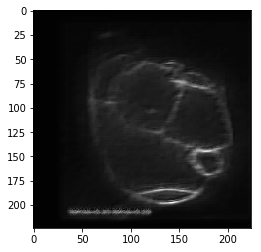

In [33]:
# img3 = np.reshape(img3, (224,224,2)) #reshape to show the image
# print(img3.shape)
# img_channel = img3[:, :, 0:1]
# print(img_channel.shape)
# img_channel = img_channel*255
# final_image = np.squeeze(img_channel) 
# plt.imshow(final_image, cmap = 'gray')


img = np.squeeze(img3)
print(img.shape)#reshape to show the image
img = img[:, :, 1]
img = img*255
# img = np.expand_dims(img, -1)
print(img.shape)
plt.imshow(img, cmap = 'gray')

In [ ]:
img3[100][0][0] + img3[100][0][1] + img3[10][0][2] #sum of probabilities of classes should be equal to 1 because we used softmax.

In [ ]:
output_image_copy = img3.copy()

output_image_copy[:, :, 2] = 0
output_image_copy[:, :, 0] = 0

#output_image_copy = output_image_copy*255
plt.imshow(output_image_copy)